In [1]:
# Necessary imports
import pylab as py
import numpy as np

import qiskit as qk
from qiskit import Aer
from qiskit import assemble

from scipy.linalg import eigvalsh, eigh

In [2]:
# Define the Pauli matrices here to reduce dependencies on other packages
X = np.array([[0,1],[1,0]],dtype=float)
Z = np.array([[1,0],[0,-1]],dtype=float)
Y = np.array([[0,-1.j],[1.j,0]],dtype=complex)
eye2 = np.array([[1,0],[0,1]],dtype=float)


# Part of the reduced Hubbard Hamiltonian
X1 = np.kron(X,eye2)
X2 = np.kron(eye2,X)
ZZ = np.kron(Z,Z)

In [3]:
# Helper function to determine the exact eigen energy (only used for plotting)

def energy_exact(t,U):
    
    ham = -t*(X1+X2) + U/2. * ZZ
    evals = eigvalsh(ham)
    return evals[0]

# Try it out
energy_exact(1.,4.)

-2.828427124746189

In [4]:
# Creates a minimal state preparation circuit with input angles that we will
# optimize.
def stateprep_circuit(th0,th1,th2,th3):
    
    qr = qk.QuantumRegister(2)
    qc = qk.QuantumCircuit(qr)

    qc.h(0)
    qc.h(1)
    
    qc.rz(th0,0)
    qc.rz(th0,1)
    
    qc.rx(np.pi/2,0)
    qc.rx(np.pi/2,1)
    
    qc.cx(0,1)    
    qc.rx(th1,0)
    qc.rz(th2,1)
    qc.cx(0,1)
    
    qc.rz(th3,0)
    qc.rz(th3,1)
    
    qc.rx(-np.pi/2,0)
    qc.rx(-np.pi/2,1)
    
    # Measurement will be added later on
    
    return qc


angles = [0.01,0.1,0.2,0.3]
qc=stateprep_circuit(*angles)
qc.draw()

┌───┐┌──────────┐┌─────────┐     ┌─────────┐     ┌─────────┐┌──────────┐
q0_0: ┤ H ├┤ RZ(0.01) ├┤ RX(π/2) ├──■──┤ RX(0.1) ├──■──┤ RZ(0.3) ├┤ RX(-π/2) ├
      ├───┤├──────────┤├─────────┤┌─┴─┐├─────────┤┌─┴─┐├─────────┤├──────────┤
q0_1: ┤ H ├┤ RZ(0.01) ├┤ RX(π/2) ├┤ X ├┤ RZ(0.2) ├┤ X ├┤ RZ(0.3) ├┤ RX(-π/2) ├
      └───┘└──────────┘└─────────┘└───┘└─────────┘└───┘└─────────┘└──────────┘

In [5]:
# Function that prepares the circuit, adds the Z 
# measurements, runs the circuit, and does some
# simple parsing to extract the 4 possible
# 2-site Z measurements.

def prepare_measure_Z(angles,nshots=2048):
    
    qc=stateprep_circuit(*angles)
    qc.measure_all()
    
    sv_sim = Aer.get_backend('qasm_simulator')
    qobj = assemble(qc,shots=nshots)
    job = sv_sim.run(qobj)
    
    res = job.result().get_counts()

    # In case we happened to get zero counts
    # for these, manually add them to the dict
    klist = ['00','01','10','11']
    for k in klist:
        if k not in res.keys():
            res[k] = 0
    
    # Possible Z measurements: II, IZ, ZI, ZZ
    meas = {}
    meas['II'] = (res['00'] + res['01'] + res['10'] + res['11'])/nshots
    meas['IZ'] = (res['00'] - res['01'] + res['10'] - res['11'])/nshots
    meas['ZI'] = (res['00'] + res['01'] - res['10'] - res['11'])/nshots
    meas['ZZ'] = (res['00'] - res['01'] - res['10'] + res['11'])/nshots

    return meas

# Function that prepares the circuit, adds the X 
# measurements, runs the circuit, and does some
# simple parsing to extract the 4 possible
# 2-site X measurements.

def prepare_measure_X(angles,nshots=2048):
    qc=stateprep_circuit(*angles)

    # Rotate into X basis
    qc.h(0)
    qc.h(1)
    
    qc.measure_all()

    sv_sim = Aer.get_backend('qasm_simulator')
    qobj = assemble(qc,shots=nshots)
    job = sv_sim.run(qobj)
    
    res = job.result().get_counts()
    
    # In case we happened to get zero counts
    # for these, manually add them to the dict
    klist = ['00','01','10','11']
    for k in klist:
        if k not in res.keys():
            res[k] = 0
    
    # Possible X measurements: II, IX, XI, XX
    meas = {}
    meas['II'] = (res['00'] + res['01'] + res['10'] + res['11'])/nshots
    meas['IX'] = (res['00'] - res['01'] + res['10'] - res['11'])/nshots
    meas['XI'] = (res['00'] + res['01'] - res['10'] - res['11'])/nshots
    meas['XX'] = (res['00'] - res['01'] - res['10'] + res['11'])/nshots
    
    return meas
    


In [6]:
def cost_function(x, parameters):
    Xmeas = prepare_measure_X(x,parameters["nshots"])
    Zmeas = prepare_measure_Z(x,parameters["nshots"])
    
    hopping = -parameters["t"] * (Xmeas['IX'] + Xmeas['XI'])
    Coulomb =  parameters["U"]/2 * Zmeas['ZZ']
    
    return hopping + Coulomb


In [7]:
def average_cost(x,parameters):
    
    N = parameters['N']
    
    accumulator = 0
    for j in range(N):
        accumulator += cost_function(x,parameters)
    return accumulator/N

def test_average_cost(t,U):
    x = np.array([0.01,0.2,0.3,0.4])*2
    parameters = {}
    parameters["t"] = t
    parameters["U"] = U
    parameters["N"] = 100
    parameters["nshots"] = 100
    
    res=average_cost(x, parameters)
    return res

test_average_cost(1.,4.)

-0.12559999999999996

In [8]:
# Test a single minimization.  We'll use the Nelder-Mead method,
# which is designed for optimizing noisy data.

def test_min(t,U):
    from scipy.optimize import minimize

    # Initial guesses inspired by the solution at large U
    x = np.array([0.6,0.7,0,0.3])*2
    
    parameters = {}
    parameters["t"] = t
    parameters["U"] = U
    parameters["N"] = 1
    parameters["nshots"] = 4096

    result = minimize(cost_function, x0 = x, args=(parameters),method='Nelder-Mead')
    print(result)
    
    # Compare to Exact Hamiltonian
    print("")
    print("Optimized energy: ",result.fun)
    print("Exact energy: ",energy_exact(t,U))
    
    
test_min(t=1.0,U=4.)

 final_simplex: (array([[9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01],
       [9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01],
       [9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01],
       [9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01],
       [9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01]]), array([-2.91308594, -2.86865234, -2.84863281, -2.84179688, -2.81201172]))
           fun: -2.9130859375
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 801
           nit: 295
        status: 1
       success: False
             x: array([9.66205723e-01, 1.53680043e+00, 3.73214749e-05, 6.37011349e-01])

Optimized energy:  -2.9130859375
Exact energy:  -2.828427124746189


In [ ]:
# Run the optimization procedure for a single t,U point.
def do_min(t,U,x):
    from scipy.optimize import minimize
    
    parameters = {}
    parameters["t"] = t
    parameters["U"] = U
    parameters["N"] = 1
    parameters["nshots"] = 8096*5

    result = minimize(average_cost, x0 = x, args=(parameters),method='Nelder-Mead')
    
    # Compare to Exact Hamiltonian
    print(U,t)
    print("Optimized energy: ",result.fun)
    print("Exact energy: ",energy_exact(t,U))
    
    return result.fun,result.x

In [9]:
# Warning -- this cell might take a bit!

# Set physics parameters: t and list of U to try
t = 1.0
Ulist = np.linspace(0,4,10)

# Initial guesses inspired by the solution at large U
guess = np.array([0.6,0.7,0,0.3])*2

# Store optimized angles and energies
opt_results = {}
Elist = np.zeros([len(Ulist),2])

# Optimize for all U values in the selected range
for iU,U in enumerate(Ulist):
    Elist[iU,0] = energy_exact(t,U)
    Elist[iU,1],coefs = do_min(t,U,guess)
    opt_results[iU] = coefs
        


0.0 1.0
Optimized energy:  -2.0
Exact energy:  -2.0
0.4444444444444444 1.0
Optimized energy:  -2.0067028985507247
Exact energy:  -2.012307808474981
0.8888888888888888 1.0
Optimized energy:  -2.0312692138779096
Exact energy:  -2.0487876571761965
1.3333333333333333 1.0
Optimized energy:  -2.1054347826086954
Exact energy:  -2.1081851067789197
1.7777777777777777 1.0
Optimized energy:  -2.185693895476504
Exact energy:  -2.1886350670658015
2.2222222222222223 1.0
Optimized energy:  -2.2976119894598153
Exact energy:  -2.2879178091082224
2.6666666666666665 1.0
Optimized energy:  -2.426581027667984
Exact energy:  -2.403700850309326
3.1111111111111107 1.0
Optimized energy:  -2.5591787439613523
Exact energy:  -2.533723166886973
3.5555555555555554 1.0
Optimized energy:  -2.7035737812911727
Exact energy:  -2.6759099063982874
4.0 1.0
Optimized energy:  -2.8575592885375496
Exact energy:  -2.828427124746189


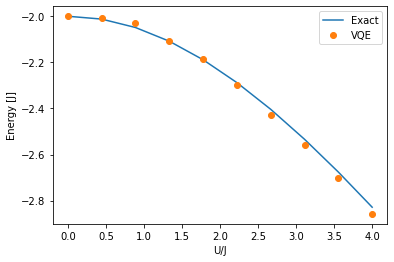

In [12]:
# Make a plot of the resulting optimized energies
fig, ax = py.subplots()
ax.plot(Ulist, Elist[:,0],label="Exact")
ax.plot(Ulist, Elist[:,1],'o',label="VQE")
ax.set_xlabel("U/J")
ax.set_ylabel("Energy [J]")
ax.legend()

In [13]:
# Sample a number of energies at the optimum to get an idea of
# the spread

def build_energy_statistics(angles):
    Nsamples = 10
    parameters = {}
    parameters["t"] = t
    parameters["U"] = U
    parameters["N"] = 1
    parameters["nshots"] = 8096
    
    energy_samples = np.zeros(Nsamples)
    for n in range(Nsamples):
        energy_samples[n] = average_cost(angles,parameters)
        
    return np.average(energy_samples),np.std(energy_samples)

en_stats = np.zeros([len(Ulist),2])
for iU,U in enumerate(Ulist):
    angles = opt_results[iU]
    en_stats[iU,:] = build_energy_statistics(angles)
    


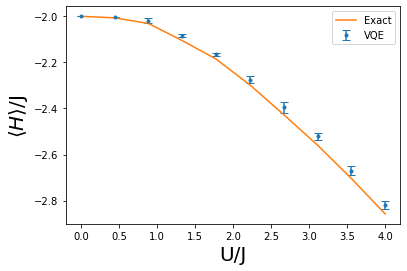

In [15]:
fig, ax = py.subplots()
ax.errorbar(Ulist, en_stats[:,0], en_stats[:,1],capsize=4,fmt='.',label='VQE')
ax.plot(Ulist,Elist[:,1],label='Exact')
ax.set_xlabel("U/J",fontsize=20)
ax.set_ylabel(r"$\langle H \rangle$/J",fontsize=20)
ax.legend()